In [2]:
import pandas as pd
import numpy as np
import csv
import random
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [296]:
# train = pd.read_csv('user_item_review_merge_table.csv')
train = pd.read_csv('merge_table_drop_na.csv')
train.head(5)

,user_id,item_id,playtime_forever,recommend
0,76561197970982479,22200,271,True
1,76561197970982479,1250,10006,True
2,76561197970982479,43110,834,True
3,js41637,227300,551,True
4,js41637,239030,349,True


In [3]:
def splitData(X, y, p1, p2): 
    X = np.array(X)
    y = np.array(y)
    sss = StratifiedShuffleSplit(n_splits=5, test_size=p1)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    sss = StratifiedShuffleSplit(n_splits=5, test_size=p2)
    X = X_train
    y = y_train
    for train_index, test_index in sss.split(X, y):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]

    print(len(y_train), len(y_valid), len(y_test))
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    

### Bought or NOT

In [4]:
def readCSV(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,t,_,_ = l.strip().split(',')
            t = int(t)
            yield u,i,t

In [79]:
timeX = []
for l in readCSV('user_item_review_merge_table.csv'):
    # if l[2] < 1000 and l[2] > 0:
    #     timeX.append(l)
    # timeX.append(l)
    if l[2] > 0:
        timeX.append(l)
len(timeX)

3286666

In [80]:
n = 800000
random.shuffle(timeX)
timeX = timeX[:n]

In [81]:
times = [t for _,_,t in timeX]

In [82]:
D = [np.percentile(times,i) for i in [20,40,60,80]]
D

[30.0, 119.0, 341.0, 1133.0]

In [83]:
def mapping(x):
    for i in range(len(D)):
        if x <= D[i]:
            return i
    return len(D)

In [84]:
timey = list(map(mapping, times))
max(timey)

4

In [85]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitData(timeX, timey, .1, .15)

612000 108000 80000


In [86]:
timePerUser = defaultdict(list)
timePerItem = defaultdict(list)
for u,i,t in X_train:
    timePerUser[u].append((i,t))
    timePerItem[i].append((u,t))

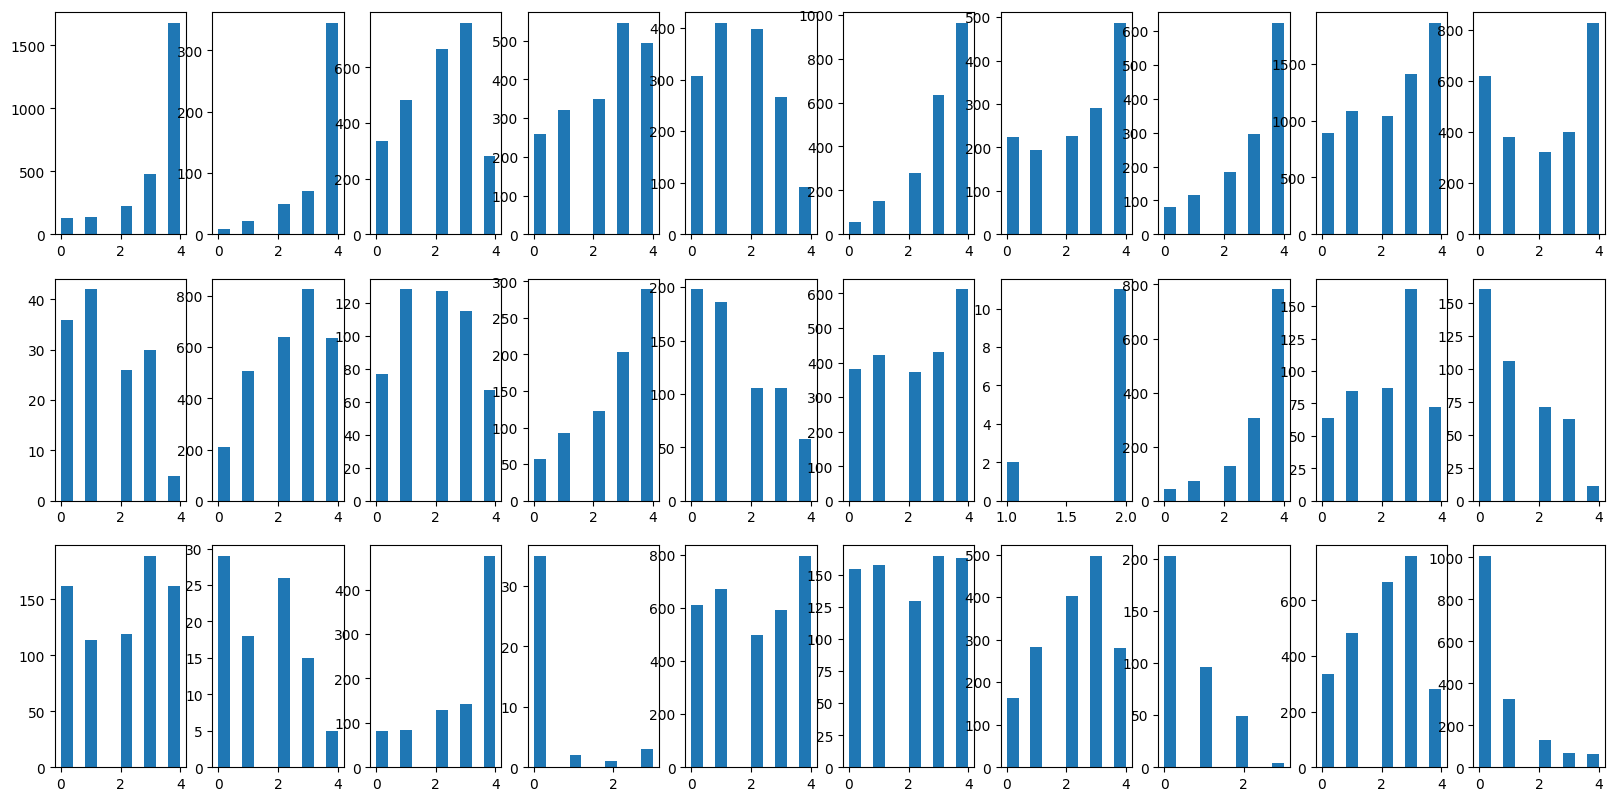

In [87]:
cnt = 0
plt.figure(figsize=(20, 10), dpi=100)
for _,i,_ in X_train:
    cnt += 1
    ts = [int(d[1]) for d in timePerItem[i]]
    ts = list(map(mapping,ts))
    plt.subplot(3,10,cnt)
    # plt.figure(cnt)
    x = plt.hist(ts)

    if cnt >= 30: break

In [34]:
N = len(X_train)
nUsers = len(timePerUser)
nItems = len(timePerItem)
users = list(timePerUser.keys())
items = list(timePerItem.keys())

In [35]:
timeMean = np.mean(y_train)
timeMed = np.median(y_train)
timeMean, timeMed

(1.9962761437908496, 2.0)

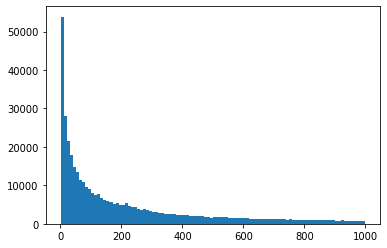

In [276]:
# times2 = [x for x in times if x > 0]
# x = plt.hist(times2, bins=100)

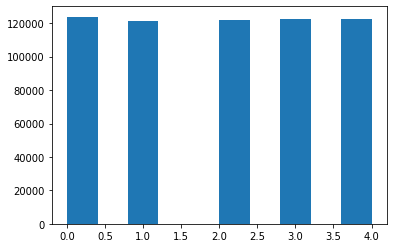

In [36]:
# times2 = [x for x in times if x < 1000 and x > 0]
x = plt.hist(y_train)

In [37]:
alpha = timeMean # median might be better than mean
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

In [38]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    global userGamma
    global itemGamma
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

def unpack(theta):
    global K
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K

def cost(theta, labels, lamb):
    global K
    unpack(theta)
    predictions = [prediction(d[0], d[1]) for d in X_train]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost

def derivative(theta, labels, lamb):
    global K
    unpack(theta)
    N = len(X_train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in timePerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in timePerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for d in X_train:
        u,i = d[0], d[1]
        pred = prediction(u, i)
        diff = pred - int(d[2])
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [39]:
K = 0
lamb = 1e-5
iter = 50
userGamma = {}
itemGamma = {}

for u in timePerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in timePerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                   [0.0]*(nUsers+nItems) + # Initialize beta
                                   [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                             derivative, 
                             args=(y_train, lamb), 
                             maxiter=iter, 
                             epsilon=1e-8)

MSE = 2.007919139427962
MSE = 2.9694707958857705
MSE = 2.048569897087324
MSE = 2.0092535494426493
MSE = 2.007877113928334
MSE = 2.007895814846205
MSE = 2.0079135732616606
MSE = 2.0079179360864607
MSE = 2.007918884202502
MSE = 2.007919085513887
MSE = 2.00791912805023
MSE = 2.0079191370244067
MSE = 2.007919138922835
MSE = 2.007919139324645
MSE = 2.007919139404221
MSE = 2.0079191394256424
MSE = 2.007919139428351
MSE = 2.007919139437337
MSE = 2.0079191394348497
MSE = 2.0079191394347475
MSE = 2.007919139427963


(array([1.99627614, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 2.007919139427963,
 {'grad': array([-3.10570851e+03, -3.28106522e-02, -6.86017088e-02, ...,
         -3.52953346e-04, -3.59598819e-05, -1.31700563e-03]),
  'task': 'ABNORMAL_TERMINATION_IN_LNSRCH',
  'funcalls': 21,
  'nit': 0,
  'warnflag': 2})

In [24]:
yPred = []
for u,i,r in X_valid:
    try:
        yPred.append(prediction(u,i))
    except:
        yPred.append(alpha)

validMSE = MSE(yPred,y_valid)
validMSE

2.461965909427604

In [47]:
K = 0
lamb = 1e1
iter = 50

userGamma = {}
itemGamma = {}

for u in timePerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in timePerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                   [0.0]*(nUsers+nItems) + # Initialize beta
                                   [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                             derivative, 
                             args=(y_valid, lamb), 
                             maxiter=iter, 
                             epsilon=1e-8)

MSE = 2.0079211233675407
MSE = 2.983125286321252
MSE = 2.05145437287039
MSE = 2.009865806138552
MSE = 2.0080081295209258
MSE = 2.007925043126612
MSE = 2.007921305653129
MSE = 2.0079211330381703
MSE = 2.007921124123595
MSE = 2.007921123470792
MSE = 2.0079211233877983
MSE = 2.0079211233717684
MSE = 2.0079211233698824
MSE = 2.007921123367792
MSE = 2.0079211233706356
MSE = 2.00792112336842
MSE = 2.0079211233671197
MSE = 2.0079211233667045
MSE = 2.007921123367531
MSE = 2.007921123366628
MSE = 2.007921123367486


(array([1.99627614, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 2.007921123367486,
 {'grad': array([-3.10570851e+03, -3.28106522e-02, -6.86017088e-02, ...,
         -3.52953346e-04, -3.59598819e-05, -1.31700563e-03]),
  'task': 'ABNORMAL_TERMINATION_IN_LNSRCH',
  'funcalls': 21,
  'nit': 0,
  'warnflag': 2})

In [42]:
yPred = []
for u,i,r in X_valid:
    try:
        yPred.append(prediction(u,i))
    except:
        yPred.append(alpha)

validMSE = MSE(yPred,y_valid)
validMSE

2.007910525866317

In [88]:
userBiases

{'L3BOYSJ': 1.5405135270673753e-18,
 'storminnorman': 3.2209618883758943e-18,
 '76561198060025649': 1.2232030202963298e-18,
 '76561198068206588': 1.7445866125834938e-19,
 '76561198042441420': 5.208900236808056e-18,
 '76561198040148259': 1.2417751451345653e-18,
 '12549': 2.204936684129605e-19,
 'klDINO': 1.5280811554033645e-18,
 '76561198045148009': 4.533759937747438e-18,
 '76561198002557471': 2.2644358379532793e-18,
 'haydenmaier1993': 4.472275248950006e-18,
 'DarkKnight2599': 3.026800044007021e-17,
 '76561198050042737': 1.3382862528615284e-18,
 'infinityskye': 2.431988705331069e-19,
 'AccelRock': 1.1871465404902772e-18,
 'Cameron_Ford97': 1.9319333845716497e-18,
 '76561198088397505': 9.195008625043757e-18,
 'tentaquil': 1.7707565566055173e-19,
 '76561198060683752': 6.7938784074135e-18,
 '76561198008724769': 3.2958601348625473e-19,
 'gabowockeez': 2.431211808477367e-18,
 'ZieSorX': 1.5489519737367824e-18,
 '76561198060660804': 1.4273040588688098e-20,
 '76561198054263357': 6.42293419505

In [95]:
itemBiases_list = [(itemBiases[x], x) for x in itemBiases]
itemBiases_list.sort()
itemBiases_list.reverse()
itemBiases_list

[(2.2520953453845036e-14, '730'),
 (1.2609158396709773e-14, '4000'),
 (4.516125564440012e-15, '105600'),
 (3.771165560563034e-15, '72850'),
 (3.4882007583868733e-15, '240'),
 (3.47855436046352e-15, '230410'),
 (2.866230139627092e-15, '218620'),
 (2.6660669493774934e-15, '550'),
 (2.4250782801525017e-15, '8930'),
 (2.369221067077984e-15, '49520'),
 (2.2245037994460105e-15, '252490'),
 (2.02858659534725e-15, '107410'),
 (1.5556557613463758e-15, '271590'),
 (1.5006975106830693e-15, '304930'),
 (1.2680781541956625e-15, '377160'),
 (1.2285765848331969e-15, '48700'),
 (1.2035088460684751e-15, '236390'),
 (1.1906102391001258e-15, '218230'),
 (1.1476798442930747e-15, '33930'),
 (1.1297228874923262e-15, '202990'),
 (1.0991763442967606e-15, '346110'),
 (1.0270646671218147e-15, '10190'),
 (1.0159569783174413e-15, '252950'),
 (1.0089704448703324e-15, '221100'),
 (1.0077350763997986e-15, '363970'),
 (9.869908853498862e-16, '22380'),
 (8.294506949905435e-16, '1250'),
 (8.140039652791346e-16, '211820

In [44]:
predictions = open("predictions_time.csv", 'w')
predictions.write('User,\tItem,\tPred,\tTrue'+ '\n')
cnt = 0
for u,i,r in X_test:
    try:
        pred = prediction(u, i)
        cnt += 1
    except:
        pred = alpha
    # print(pred)
    predictions.write(u + ',\t' + i + ',\t' + str(pred) + ',\t' + str(mapping(int(r))) + '\n')
    
predictions.close()

print(cnt,'/',len(X_test))

78872 / 80000


### PlayafterBuy or NOT

In [389]:
def readCSV2(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,_,p,_ = l.strip().split(',')
            p = 1 if p == 'True' else 0
            yield u,i,p

In [14]:
def Jaccard(s1, s2):
    return len(s1.intersection(s2))/len(s1.union(s2))

In [13]:
def prepare(Train):
    item0Count = defaultdict(int)
    item1Count = defaultdict(int)
    total0 = 0
    total1 = 0
    item0PerUser = defaultdict(set)
    item1PerUser = defaultdict(set)
    userPerItem0 = defaultdict(set)
    userPerItem1 = defaultdict(set)
    item0Set = set()
    item1Set = set()

    for u,i,p in Train:    
        if int(p):
            item1Count[i] += 1
            total1 += 1
            item1Set.add(i)
            item1PerUser[u].add(i)
            userPerItem1[i].add(u)
        else:
            item0Count[i] += 1
            total0 += 1
            item0Set.add(i)
            item0PerUser[u].add(i)
            userPerItem0[i].add(u)
            
    mostPopular0 = [(item0Count[x], x) for x in item0Count]
    mostPopular1 = [(item1Count[x], x) for x in item1Count]
    mostPopular0.sort()
    mostPopular0.reverse()
    mostPopular1.sort()
    mostPopular1.reverse()

    return mostPopular0, mostPopular1, item0PerUser, item1PerUser, userPerItem0, userPerItem1

In [391]:
playX = []
for l in readCSV2('user_item_review_merge_table.csv'):
    playX.append(l)
len(playX)

5154633

In [392]:
n = 800000
random.shuffle(playX)
playX = playX[:n]


In [393]:
playy = [t for _,_,t in playX]

In [394]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitData(playX, playy, .1, .15)

612000 108000 80000


In [395]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(X_train)

In [396]:
len(set(mostPopular0)), len(set(mostPopular1))

(7528, 7412)

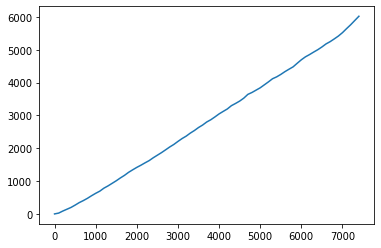

In [397]:
x = [i for i in range(1, min([len(set(mostPopular0)), len(set(mostPopular1))]), 100)]
y = []
for n in x:
    y.append(len(set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])))

plt.plot(x,y)

In [15]:
def getPred(X, thres1, output=False):
    yPred = []
    n = round(min([len(set(mostPopular0)), len(set(mostPopular1))])*thres1)
    union = set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])
    popularSet0 = set([x[1] for x in mostPopular0[:n]]) - union
    popularSet1 = set([x[1] for x in mostPopular1[:n]]) - union

    l = len(X)
    cnt = 0
    for u,i,_ in X:
        cnt += 1

        if i in popularSet0:
            yPred.append(0)
            continue
        
        if i in popularSet1:
            yPred.append(1)
            continue
        
        maxSimilarity0 = 0
        gSet = set(userPerGame0[i])
        for g_prime in game0PerUser[u]:
            g_priSet = set(userPerGame0[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity0 = max(maxSimilarity0, similarity)
        
        maxSimilarity1 = 0
        gSet = set(userPerGame1[i])
        for g_prime in game1PerUser[u]:
            g_priSet = set(userPerGame1[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity1 = max(maxSimilarity1, similarity)
        # print(maxSimilarity0 , maxSimilarity1)
        if maxSimilarity0 > maxSimilarity1:
            yPred.append(0)
            continue
      
        yPred.append(1)

        if output and cnt%1000 == 0:
            print(cnt, '/', l)

    return yPred

In [399]:
thres1 = .025
pred = getPred(X_valid, thres1, output=True)

3000 / 108000
4000 / 108000
6000 / 108000
8000 / 108000
10000 / 108000
13000 / 108000
15000 / 108000
18000 / 108000
22000 / 108000
27000 / 108000
29000 / 108000
31000 / 108000
33000 / 108000
34000 / 108000
35000 / 108000
36000 / 108000
37000 / 108000
39000 / 108000
41000 / 108000
45000 / 108000
50000 / 108000
51000 / 108000
55000 / 108000
56000 / 108000
57000 / 108000
60000 / 108000
61000 / 108000
62000 / 108000
63000 / 108000
64000 / 108000
65000 / 108000
67000 / 108000
69000 / 108000
70000 / 108000
71000 / 108000
73000 / 108000
77000 / 108000
80000 / 108000
83000 / 108000
85000 / 108000
91000 / 108000
93000 / 108000
95000 / 108000
97000 / 108000
98000 / 108000
101000 / 108000
102000 / 108000
104000 / 108000
107000 / 108000
108000 / 108000


In [400]:
acc = metrics.accuracy_score(y_valid, pred)
TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
print('acc: ', acc)
print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres1)

acc:  0.7426111111111111
TN:  26770 FP: 12376 FN:  15422 TP:  53432  |  thres:  0.025


In [403]:
thresLst = [.01,.05,.1,.3,.5,.7,.9]
print('-'*30+'PlayafterBuy or NOT'+'-'*30)
for thres in thresLst:
    pred = getPred(X_valid, thres)
    acc = metrics.accuracy_score(y_valid, pred)
    TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
    print('Acc: ', acc)
    print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)


------------------------------PlayafterBuy or NOT------------------------------
Acc:  0.737175925925926
TN:  27315 FP: 11831 FN:  16554 TP:  52300  |  thres:  0.01
Acc:  0.7420925925925926
TN:  25465 FP: 13681 FN:  14173 TP:  54681  |  thres:  0.05
Acc:  0.740574074074074
TN:  24363 FP: 14783 FN:  13235 TP:  55619  |  thres:  0.1
Acc:  0.7303240740740741
TN:  24038 FP: 15108 FN:  14017 TP:  54837  |  thres:  0.3
Acc:  0.7245462962962963
TN:  23969 FP: 15177 FN:  14572 TP:  54282  |  thres:  0.5
Acc:  0.7228240740740741
TN:  23967 FP: 15179 FN:  14756 TP:  54098  |  thres:  0.7
Acc:  0.7223611111111111
TN:  24019 FP: 15127 FN:  14858 TP:  53996  |  thres:  0.9


In [262]:
thres = .05
pred = getPred(X_test, thres)
acc = metrics.accuracy_score(y_test, pred)
TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()
print('acc: ', acc)
print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)

acc:  0.73302
TN:  11054 FP: 7067 FN:  6282 TP:  25597  |  thres:  0.05


### Recommend or NOT

In [4]:
def readCSV3(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,_,r = l.strip().split(',')
            r = 1 if r == 'True' else 0
            yield u,i,r

In [7]:
def readCSV4(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,_,_,r = l.strip().split(',')
            r = 1 if r == 'True' else 0
            yield u,i,r

In [8]:
recX = []
recy = []
# for l in readCSV3('merge_table_drop_na.csv'):
for l in readCSV4('recommend.csv'):
    recX.append(l)
    recy.append(l[2])
len(recy)

1914191

In [27]:
n = sum(recy)
new_X = [x for x in recX if x[2]==1]
all_y = [x for x in recX if x[2]==0]
for i in range(len(new_X)):
    new_X.append(random.choice(all_y))

In [30]:
new_y = [x[2] for x in new_X]

In [34]:
recX, recy = new_X, new_y

In [35]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitData(recX, recy, .1, .15)

62992 11117 8235


In [32]:
X_train

array([['bohemianknight', '204030', '0'],
       ['76561198039746024', '6020', '0'],
       ['Pickles_was_here', '730', '1'],
       ...,
       ['76561198079079942', '8000', '0'],
       ['worldtradecentre', '211820', '1'],
       ['76561198059286499', '50', '0']], dtype='<U32')

In [36]:
sum(np.array(recy))/len(recy)

0.5

In [37]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(X_train)

In [38]:
len(set(mostPopular0)), len(set(mostPopular1))

(4517, 2504)

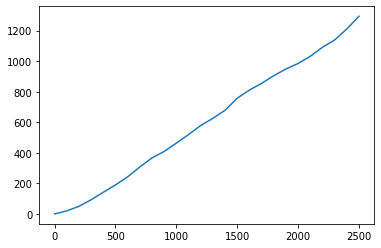

In [39]:
x = [i for i in range(1, min([len(set(mostPopular0)), len(set(mostPopular1))]), 100)]
y = []
for n in x:
    y.append(len(set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])))

plt.plot(x,y)

In [40]:
thresLst = [.01,.05,.1,.3,.5,.7,.9]
print('-'*30+'Recommend or NOT'+'-'*30)
for thres in thresLst:
    pred = getPred(X_valid, thres)
    acc = metrics.accuracy_score(y_valid, pred)
    TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
    print('acc: ', acc)
    print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)

------------------------------Recommend or NOT------------------------------
acc:  0.5951245839704956
TN:  1147 FP: 4411 FN:  90 TP:  5469  |  thres:  0.01
acc:  0.6406404605559054
TN:  1769 FP: 3789 FN:  206 TP:  5353  |  thres:  0.05
acc:  0.6669964918593145
TN:  2055 FP: 3503 FN:  199 TP:  5360  |  thres:  0.1
acc:  0.6891247638751462
TN:  2251 FP: 3307 FN:  149 TP:  5410  |  thres:  0.3
acc:  0.6866060987676531
TN:  2229 FP: 3329 FN:  155 TP:  5404  |  thres:  0.5
acc:  0.6819285778537375
TN:  2183 FP: 3375 FN:  161 TP:  5398  |  thres:  0.7
acc:  0.6837276243590897
TN:  2203 FP: 3355 FN:  161 TP:  5398  |  thres:  0.9
